<a href="https://colab.research.google.com/github/arshiabagchi/Image-Segmentation-with-Lane-Detection/blob/main/Image_Segmentation_and_Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SegNet-Tutorial-master.zip to SegNet-Tutorial-master (1).zip


In [ ]:
import os
os.listdir("/content/SegNet-Tutorial-master")

['README.md',
 'Example_Models',
 'Scripts',
 '.gitattributes',
 '.gitignore',
 'docker',
 'CamVid',
 'Models']

IMAGE SEGMENTATION

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

base_path = "/content/SegNet-Tutorial-master/CamVid/"

train_img_dir = base_path + "train/"
train_mask_dir = base_path + "trainannot/"
val_img_dir   = base_path + "val/"
val_mask_dir  = base_path + "valannot/"

IMG_SIZE = 256
N_CLASSES = 12

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

In [ ]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

In [ ]:
def create_dataset(img_dir, mask_dir, batch=4):
    image_files = sorted(os.listdir(img_dir))

    def generator():
        for name in image_files:
            img = load_image(os.path.join(img_dir, name))
            mask = load_mask(os.path.join(mask_dir, name))
            yield img, mask

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.uint8),
        output_shapes=(
            [IMG_SIZE, IMG_SIZE, 3],
            [IMG_SIZE, IMG_SIZE, 1]
        )
    )

    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = create_dataset(train_img_dir, train_mask_dir)
val_ds   = create_dataset(val_img_dir, val_mask_dir)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)


/tmp/ipython-input-4243168283.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
layers = [
    "block_1_expand_relu",
    "block_3_expand_relu",
    "block_6_expand_relu",
    "block_13_expand_relu",
    "block_16_project"
]


In [ ]:
encoder_outputs = [base_model.get_layer(x).output for x in layers]
encoder = tf.keras.Model(inputs=base_model.input, outputs=encoder_outputs)
encoder.trainable = False

In [ ]:
def upsample(filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, 3, strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

ups = [
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
]

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
skip_outputs = encoder(inputs)

x = skip_outputs[-1]
skips = reversed(skip_outputs[:-1])

In [ ]:
for up, skip in zip(ups, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

# Final segmentation layer
last_layer = tf.keras.layers.Conv2DTranspose(
    N_CLASSES, 3, strides=2, padding="same"
)

outputs = last_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 128, 128, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │  1,477,120 │ functional[0][4]  │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │  2,508,032 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64, 64,    │    516,736 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 128, 128,  │    156,992 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 256, 256,  │     17,292 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 12)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,518,156 (24.86 MB)

 Trainable params: 4,674,252 (17.83 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35
)

print("\n==== Training Completed Successfully! ====")

Epoch 1/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7942 - loss: 0.6961 - val_accuracy: 0.8247 - val_loss: 0.6002
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8056 - loss: 0.6534 - val_accuracy: 0.8300 - val_loss: 0.5744
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8151 - loss: 0.6148 - val_accuracy: 0.8349 - val_loss: 0.5574
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8230 - loss: 0.5832 - val_accuracy: 0.8423 - val_loss: 0.5297
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8300 - loss: 0.5557 - val_accuracy: 0.8449 - val_loss: 0.5116
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8372 - loss: 0.5285 - val_accuracy: 0.8481 - val_loss: 0.4934
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8429 - loss: 0.5067 - val_accuracy: 0.8518 - val_loss: 0.4736
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8496 - loss: 0.4829 - val_accuracy: 0.8522 - v

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=55,
    initial_epoch=35,
    callbacks=[callback]
)


Epoch 36/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9302 - loss: 0.2078 - val_accuracy: 0.8749 - val_loss: 0.4127
Epoch 37/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9304 - loss: 0.2067 - val_accuracy: 0.8730 - val_loss: 0.4216
Epoch 38/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9310 - loss: 0.2043 - val_accuracy: 0.8723 - val_loss: 0.4290
Epoch 39/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9332 - loss: 0.1977 - val_accuracy: 0.8745 - val_loss: 0.4216
Epoch 40/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9352 - loss: 0.1917 - val_accuracy: 0.8765 - val_loss: 0.4226
Epoch 41/55
92/92 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9377 - loss: 0.1848 - val_accuracy: 0.8793 - val_loss: 0.4129


Total validation images: 101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


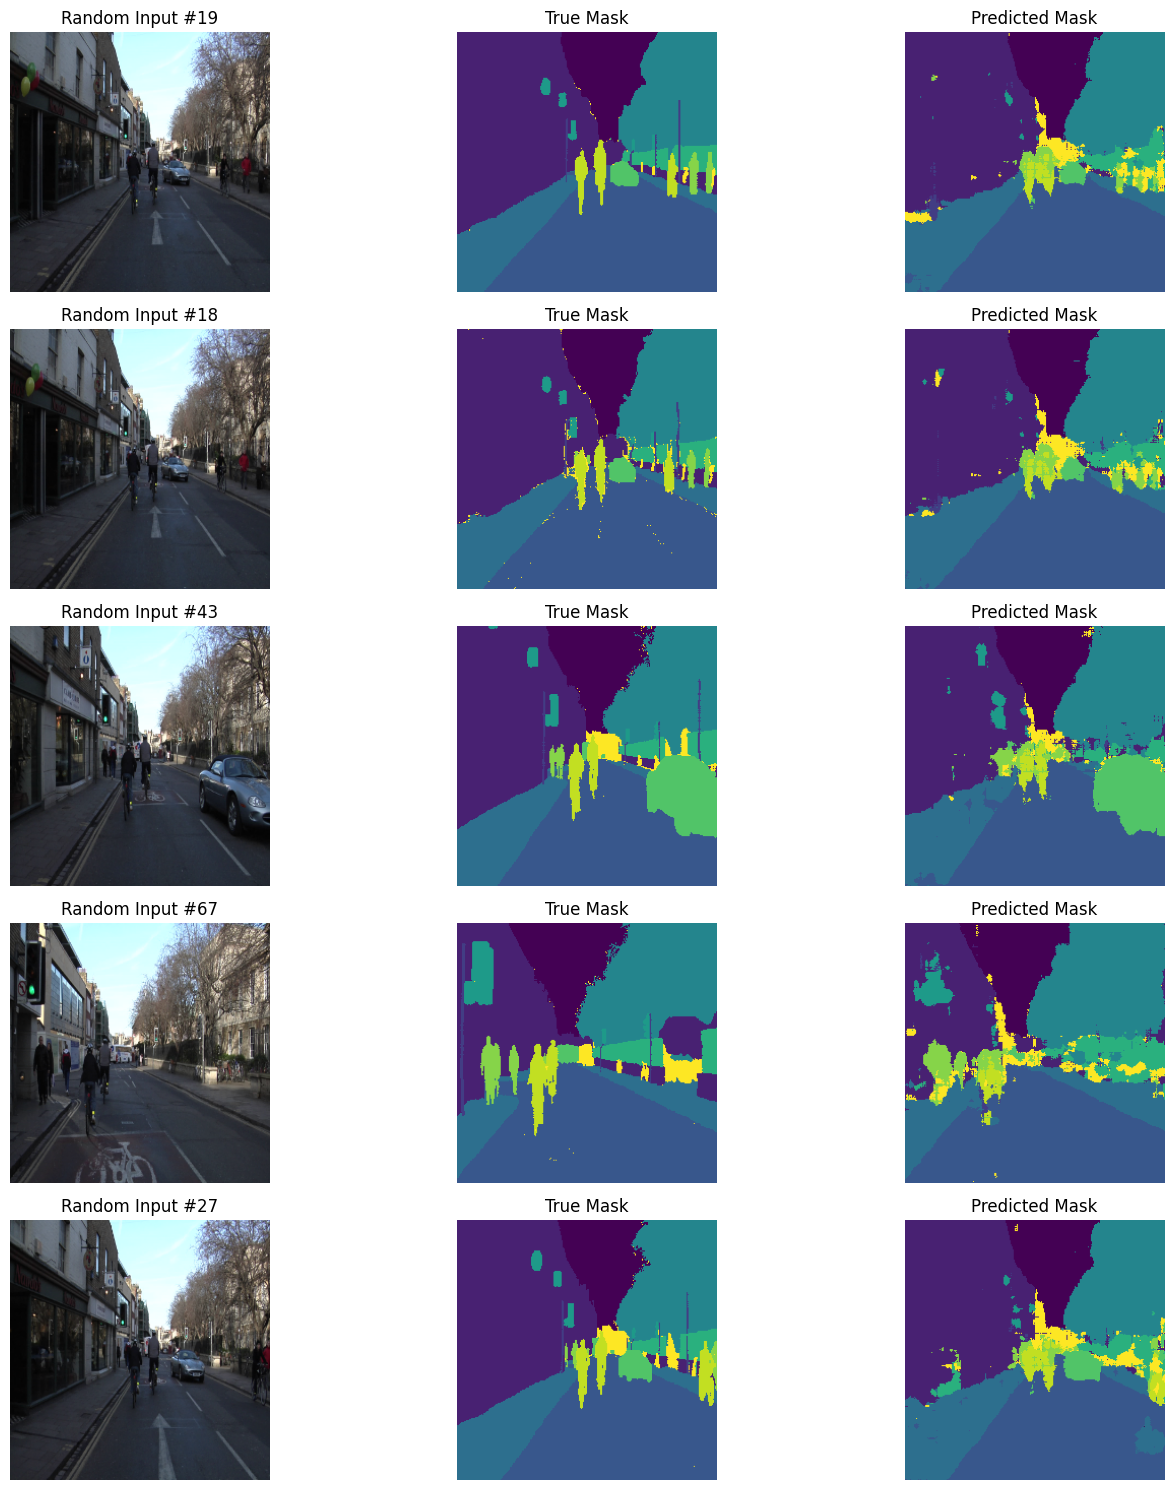

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

all_val_images = []
all_val_masks = []

for batch in val_ds:
    imgs, masks = batch
    all_val_images.append(imgs.numpy())
    all_val_masks.append(masks.numpy())

all_val_images = np.concatenate(all_val_images, axis=0)
all_val_masks = np.concatenate(all_val_masks, axis=0)

print("Total validation images:", len(all_val_images))

num_samples = 5
indices = random.sample(range(len(all_val_images)), num_samples)

plt.figure(figsize=(15, num_samples * 3))

for idx, i in enumerate(indices):

    img = all_val_images[i]
    mask = all_val_masks[i].squeeze()

    pred = model.predict(img[None, ...])
    pred_mask = np.argmax(pred[0], axis=-1)

    # Input
    plt.subplot(num_samples, 3, idx*3 + 1)
    plt.imshow(img)
    plt.title(f"Random Input #{i}")
    plt.axis("off")

    # True mask
    plt.subplot(num_samples, 3, idx*3 + 2)
    plt.imshow(mask)
    plt.title("True Mask")
    plt.axis("off")

    # Predicted mask
    plt.subplot(num_samples, 3, idx*3 + 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


LANE DETECTION

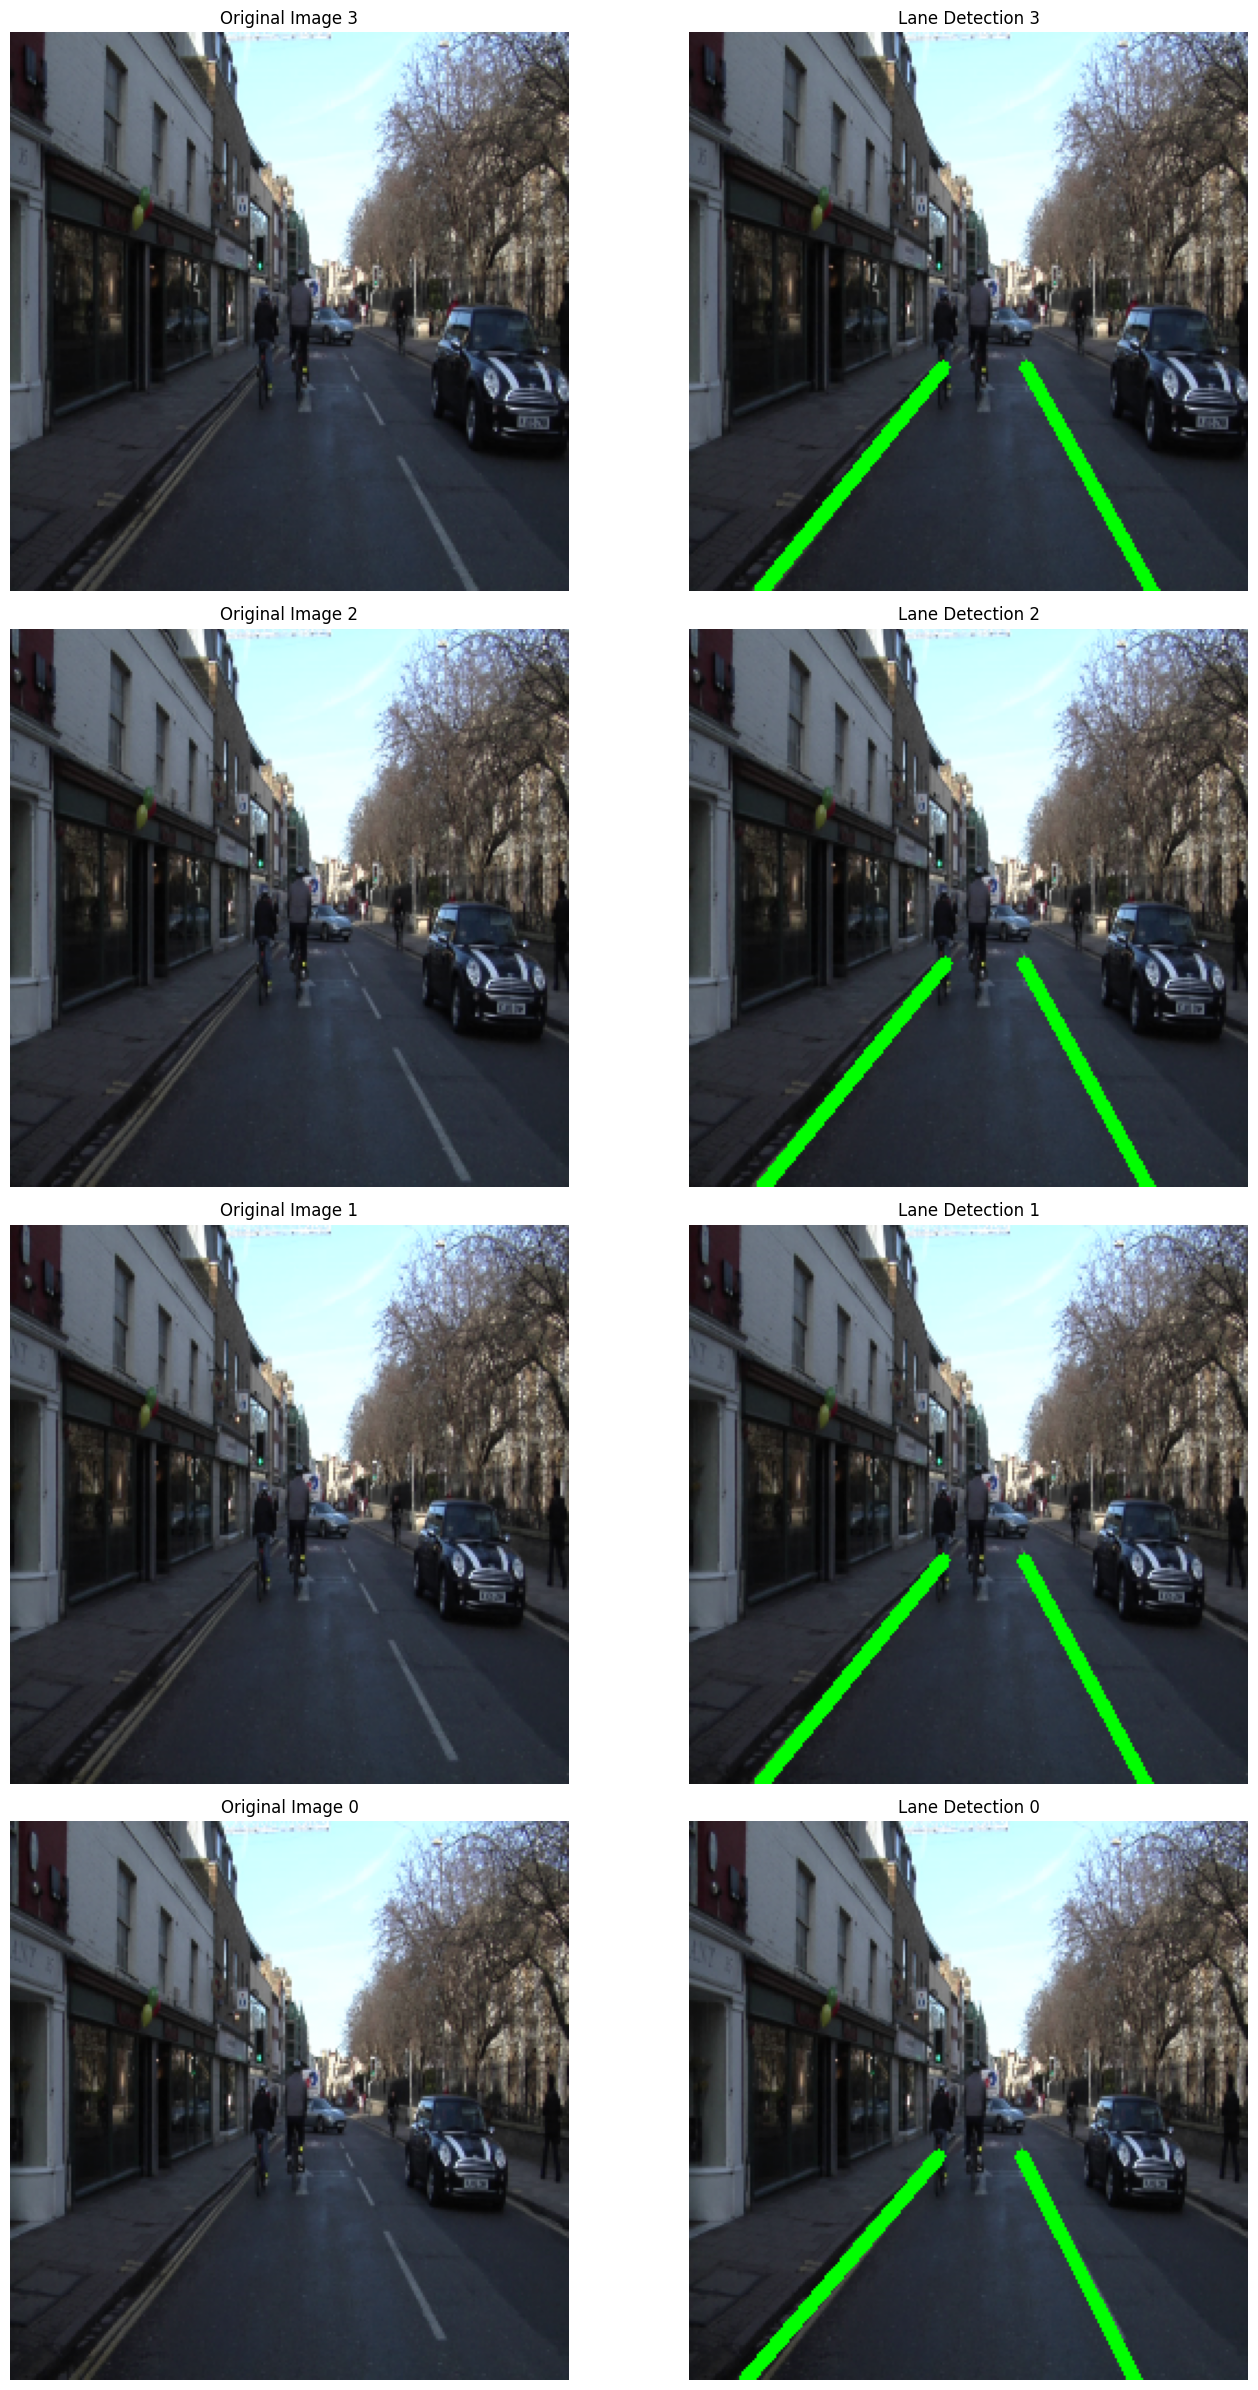

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

num_samples = 5
num_samples = min(num_samples, len(val_images))
indices = random.sample(range(len(val_images)), num_samples)

def lane_detection_full(img):
    img_ = (img*255).astype(np.uint8)
    gray = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    h, w = edges.shape
    mask = np.zeros_like(edges)

    polygon = np.array([[
        (int(0.1*w), h),
        (int(0.45*w), int(0.6*h)),
        (int(0.55*w), int(0.6*h)),
        (int(0.9*w), h)
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(cropped_edges, 1, np.pi/180, 30, minLineLength=40, maxLineGap=25)

    lane_img = img_.copy()
    if lines is None:
        return lane_img

    left_pts = []
    right_pts = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2-y1)/(x2-x1+1e-6)
        if slope < -0.3:  # Left lane
            left_pts.append((x1, y1))
            left_pts.append((x2, y2))
        elif slope > 0.3:  # Right lane
            right_pts.append((x1, y1))
            right_pts.append((x2, y2))

    def fit_line(pts):
        if len(pts) == 0:
            return None
        x = np.array([p[0] for p in pts])
        y = np.array([p[1] for p in pts])
        m, b = np.polyfit(x, y, 1)
        y1_new = h
        y2_new = int(0.6*h)
        x1_new = int((y1_new - b)/m)
        x2_new = int((y2_new - b)/m)
        return (x1_new, y1_new, x2_new, y2_new)

    left_line = fit_line(left_pts)
    right_line = fit_line(right_pts)

    if left_line:
        cv2.line(lane_img, (left_line[0], left_line[1]), (left_line[2], left_line[3]), (0,255,0), 5)
    if right_line:
        cv2.line(lane_img, (right_line[0], right_line[1]), (right_line[2], right_line[3]), (0,255,0), 5)

    return lane_img

plt.figure(figsize=(15, num_samples*6))

for j, i in enumerate(indices):
    original_img = (val_images[i]*255).astype(np.uint8)
    lane_img = lane_detection_full(val_images[i])

    # Original image
    plt.subplot(num_samples, 2, 2*j + 1)
    plt.title(f"Original Image {i}")
    plt.imshow(original_img)
    plt.axis("off")

    # Lane-detected output
    plt.subplot(num_samples, 2, 2*j + 2)
    plt.title(f"Lane Detection {i}")
    plt.imshow(lane_img)
    plt.axis("off")

plt.tight_layout()
plt.show()
